# Helpers and things I have created for fetching hex maze data

In [ ]:
import spyglass.common as sgc
import spyglass.position as sgp
import spyglass.data_import as sgi

from hexmaze import plot_hex_maze
from hex_maze_behavior import HexMazeBlock, HexPosition, HexPath, HexMazeChoice
from berke_fiber_photometry import FiberPhotometrySeries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[2025-11-18 16:24:00,561][INFO]: DataJoint 0.14.6 connected to yshwang@lmf-db.cin.ucsf.edu:3306


## Fetch data from `HexMazeBlock` and `HexMazeBlock.Trial` tables

Both of these tables have the secondary key `interval_list_name`, so we can't do a regular join using `*`.

I have a function `HexMazeBlock().join_with_trial()` that automatically renames these to `block_interval_list_name` and `trial_interval_list_name` so we can join them

In [ ]:
nwb_file_name = 'IM-1478_20220726_.nwb'
HexPath() & {'nwb_file_name': nwb_file_name}

pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_path_object_id
cfe6c111-1aa1-a41d-858c-f307e7a53b7c,IM-1478_20220726_.nwb,0,IM-1478_20220726_NUZ88JR3YS.nwb,3a7434c0-2b3f-4557-aa18-6ce55eeb4f5a
d99e7241-3d87-5b76-43e8-ca971ffc9100,IM-1478_20220726_.nwb,0,IM-1478_20220726_JCSD8TQNTC.nwb,26e6f12b-a4f0-40b7-ba3e-96980d2758a0


In [53]:
# mannually specify pos_merge_id
pos_merge_id = "cfe6c111-1aa1-a41d-858c-f307e7a53b7c"

# Example of fetching data from HexPath table
hex_path_key = {"pos_merge_id": pos_merge_id}
display(HexPath() & hex_path_key)

# Get hex path dataframe for the whole epoch
epoch_df = (HexPath & hex_path_key).fetch1_dataframe()
display(epoch_df)

pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_path_object_id
cfe6c111-1aa1-a41d-858c-f307e7a53b7c,IM-1478_20220726_.nwb,0,IM-1478_20220726_NUZ88JR3YS.nwb,3a7434c0-2b3f-4557-aa18-6ce55eeb4f5a


,block,block_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion
id,,,,,,,,,,,,
0,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen
1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen
2,1,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start
3,1,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start
4,1,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start
...,...,...,...,...,...,...,...,...,...,...,...,...
2965,3,12,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen
2966,3,12,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen
2967,3,12,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen


# *RAMP Pipeline*
1. Calculate average `z_scored_green_dFF` between each hex's `entry_time` and `exit_time` and add that column
2. Plot the ramp approaching to the goal (first, all of trials)
3. Get trial information based on conditions (rewarded? unrewarded? swr? no-swr? unrewarded_rewarded? rewarded_unrewarded?)
4. Plot the ramp given that information of trials

### 1.  Calculate average `z_scored_green_dFF` between each hex's `entry_time` and `exit_time` and add that column

In [ ]:
def average_hex_z_scored_green_dFF(epoch_df, phot_series):
    """
    Calculate the average z_scored_green_dFF between each hex's entry_time and exit_time.

    Parameters:
    epoch_df (pd.DataFrame): DataFrame containing hex path data with 'entry_time' and 'exit_time' columns.
    phot_series (FiberPhotometryResponseSeries): Photometry series object containing timestamps and data.

    Returns:
    pd.DataFrame: Updated DataFrame with a new column 'avg_z_scored_green_dFF'.
    """
    avg_dFF_list = []

    timestamps = phot_series.get_timestamps()
    data = phot_series.data[:]

    for _, row in epoch_df.iterrows():
        entry_time = row['entry_time']
        exit_time = row['exit_time']

        # Find indices of timestamps within the entry and exit time
        indices = np.where((timestamps >= entry_time) & (timestamps <= exit_time))[0]

        if len(indices) > 0:
            avg_dFF = np.mean(data[indices])
        else:
            avg_dFF = np.nan  # No data in this interval

        avg_dFF_list.append(avg_dFF)

    epoch_df['avg_z_scored_green_dFF'] = avg_dFF_list
    return epoch_df

,block,block_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion
id,,,,,,,,,,,,
0,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen
1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen
2,1,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start
3,1,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start
4,1,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start
...,...,...,...,...,...,...,...,...,...,...,...,...
2965,3,12,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen
2966,3,12,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen
2967,3,12,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen


Text(0, 0.5, 'Photometry series data')

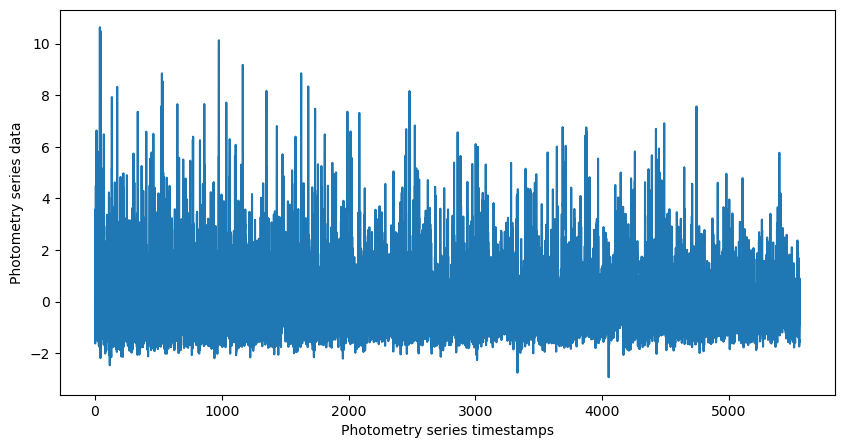

In [ ]:
# Get hex path dataframe for the whole epoch
epoch_df = (HexPath & hex_path_key).fetch1_dataframe()
display(epoch_df)

# Fetch the a specific nwb FiberPhotometryResponseSeries object by name
series_name = "z_scored_green_dFF"
phot_series = FiberPhotometrySeries.fetch_series(nwb_file_name=nwb_file_name, series_name=series_name)

plt.figure(figsize = (10, 5))
plt.plot(phot_series.get_timestamps(), phot_series.data[:])
plt.xlabel('Photometry series timestamps')
plt.ylabel('Photometry series data')

In [33]:
epoch_df_dff = average_hex_z_scored_green_dFF(epoch_df, phot_series)
display(epoch_df_dff)

,block,block_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,
0,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen,2.605692
1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen,0.967906
2,1,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start,0.817231
3,1,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start,-0.224777
4,1,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start,0.400566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,3,12,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen,-0.872425
2966,3,12,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen,-0.941935
2967,3,12,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen,-0.544739


### 2. Plot the ramp approaching to the goal (first, all of trials)
- epoch_df_dff has `hexes_from_end`, `hex_type`, and `hex_entry_num` to filter the hex to combine the `avg_z_scored_green_dff`
- we average the `avg_z_scored_green_dff` on the same of `hexes_from_end` when `'hex_type' == 'optimal'`, for now, ignore `hex_entry_num`

In [66]:
def group_dff_by_hexes_from_end(epoch_df_dff, hex_type='optimal', pick_max_hex_entry_num=False):
    """
    Group avg_z_scored_green_dFF by hexes_from_end for rows with given hex_type.

    Parameters:
    - epoch_df_dff: pd.DataFrame with columns ['block','block_trial_num','hexes_from_end',
      'hex_type','hex_entry_num','avg_z_scored_green_dFF']
    - hex_type: filter by this hex_type (default 'optimal')
    - pick_max_hex_entry_num: if True, for each (block, block_trial_num, hexes_from_end)
      keep only the row with the max hex_entry_num (useful to pick last revisit)

    Returns:
    - dict mapping hexes_from_end -> list of avg_z_scored_green_dFF (NaNs are dropped)
    """

    df = epoch_df_dff

    if pick_max_hex_entry_num:
        # keep the last visit per trial/hexes_from_end (largest hex_entry_num)
        df = df.sort_values('hex_entry_num').drop_duplicates(
            subset=['block', 'block_trial_num', 'hexes_from_end'],
            keep='last'
        )

    # filter by hex_type
    if hex_type:
        df = df[df['hex_type'] == hex_type]

    dff_by_hexes_from_end = (df
             .groupby('hexes_from_end')['avg_z_scored_green_dFF']
             .agg(['mean', 'count', 'std'])
             .dropna())
    # compute sem = std / sqrt(count); avoid division by zero
    dff_by_hexes_from_end['sem'] = dff_by_hexes_from_end['std'] / np.sqrt(dff_by_hexes_from_end['count'].replace(0, np.nan))

    return dff_by_hexes_from_end

In [67]:
dff_by_hexes_from_end = group_dff_by_hexes_from_end(epoch_df_dff, hex_type='optimal')
display(dff_by_hexes_from_end)

,mean,count,std,sem
hexes_from_end,,,,
0,0.201492,138,0.423916,0.036086
1,0.171736,141,0.643784,0.054216
2,0.092936,137,0.539790,0.046117
3,-0.016570,143,0.547258,0.045764
4,-0.136348,163,0.575473,0.045075
5,-0.108736,158,0.657820,0.052333
6,-0.225087,144,0.598506,0.049875
7,-0.376882,43,0.501389,0.076461
8,-0.376407,157,0.544156,0.043428


In [78]:
def plot_dff_ramp(dff_by_hexes_from_end, exclude_end_port=False, max_hexes_from_end=False, plot_sem=True):

    df = dff_by_hexes_from_end
    
    if exclude_end_port:
        df = df.loc[df.index != 0]

    if max_hexes_from_end:
        df = df.loc[df.index <= max_hexes_from_end]
        
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df['mean'], label='mean')
    if plot_sem:
        plt.fill_between(df.index, df['mean'] - df['sem'], df['mean'] + df['sem'], color='C0', alpha=0.25, label='± sem')
    plt.xlabel('Hexes from end')
    plt.ylabel('Average z-scored green dFF')
    # reverse x axis so it goes from max -> min
    plt.xlim(df.index.max(), df.index.min())
    plt.xticks(np.arange(df.index.max(), df.index.min()-1, -1))
    plt.legend()
    plt.show()

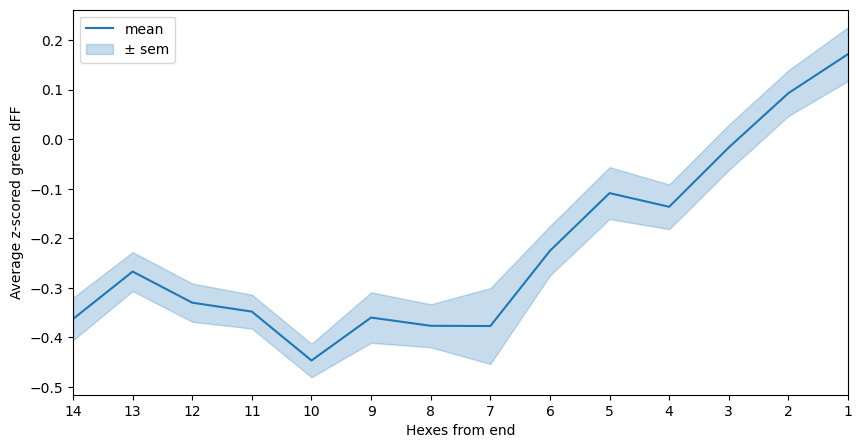

In [79]:
plot_dff_ramp(dff_by_hexes_from_end, exclude_end_port=True, max_hexes_from_end=14) 

### 3. Get trial information based on conditions (rewarded? unrewarded? swr? no-swr? unrewarded_rewarded? rewarded_unrewarded?)

In [92]:
df = pd.DataFrame((HexMazeChoice() * HexMazeBlock().join_with_trial() * sgc.Session() & {'nwb_file_name': nwb_file_name}).fetch(as_dict=True))
print(df.columns)
df.head()

Index(['nwb_file_name', 'epoch', 'block', 'block_trial_num',
       'choice_direction', 'reward_prob_diff', 'path_length_diff', 'config_id',
       'block_interval_list_name', 'p_a', 'p_b', 'p_c', 'num_trials',
       'task_type', 'trial_interval_list_name', 'epoch_trial_num', 'reward',
       'start_port', 'end_port', 'opto_cond', 'poke_interval', 'duration',
       'subject_id', 'institution_name', 'lab_name', 'session_id',
       'session_description', 'session_start_time',
       'timestamps_reference_time', 'experiment_description'],
      dtype='object')


,nwb_file_name,epoch,block,block_trial_num,choice_direction,reward_prob_diff,path_length_diff,config_id,block_interval_list_name,p_a,...,poke_interval,duration,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
0,IM-1478_20220726_.nwb,0,1,2,left,40.0,-2.0,"5,15,16,18,22,29,36,44,45",epoch0_block1,90.0,...,"[69.228, 74.12250240000337]",19.7859,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze ta...,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task
1,IM-1478_20220726_.nwb,0,1,3,right,-40.0,-2.0,"5,15,16,18,22,29,36,44,45",epoch0_block1,90.0,...,"[106.528, 108.44085760000348]",34.3184,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze ta...,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task
2,IM-1478_20220726_.nwb,0,1,4,right,-40.0,2.0,"5,15,16,18,22,29,36,44,45",epoch0_block1,90.0,...,"[132.54, 140.2933951999992]",31.8525,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze ta...,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task
3,IM-1478_20220726_.nwb,0,1,5,left,-80.0,0.0,"5,15,16,18,22,29,36,44,45",epoch0_block1,90.0,...,"[152.896, 164.43391999999434]",24.1405,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze ta...,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task
4,IM-1478_20220726_.nwb,0,1,6,left,40.0,-2.0,"5,15,16,18,22,29,36,44,45",epoch0_block1,90.0,...,"[174.56, 189.60823039999605]",25.1743,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze ta...,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task


In [ ]:
#TODO : The trial info dataframes need fix. visits should be all to the same port. or idk if this have to be exactly re-visiting immediately, or not.

In [147]:
def get_trial_info(df, reward_t_2=[0, 1], reward_t_1=[0, 1]):
    '''
    output is getting 'block', 'block_trial_num'
    scanning through each row of df to filter trials based on the conditions
    first two index is skipped as there is no t-2 info for the first trial
    '''
    current_trial_info = []
    prev_trial_info = []
    
    for idx, row in df.iterrows():
        if idx == 0 or idx == 1 or idx == 2 or idx == 3:
            continue  # skip first four rows

        reward_prev = df.loc[idx - 2, 'reward']
        reward_two_prev = df.loc[idx - 4, 'reward'] if idx - 4 >= 0 else None

        if (reward_prev in reward_t_1) and (reward_two_prev in reward_t_2) and df.loc[idx-4, 'end_port'] == df.loc[idx-2, 'end_port'] == df.loc[idx, 'end_port']:
            current_trial_info.append({
                'block': row['block'],
                'block_trial_num': row['block_trial_num']
            })
            prev_trial_info.append({
                'block': df.loc[idx - 1, 'block'],
                'block_trial_num': df.loc[idx - 1, 'block_trial_num']
            })
    return pd.DataFrame(prev_trial_info), pd.DataFrame(current_trial_info)

In [164]:
prev_trial_info, current_trial_info = get_trial_info(df, reward_t_2=[0], reward_t_1=[1])
print(len(prev_trial_info), len(current_trial_info))
print(prev_trial_info)
print(current_trial_info)

3 3
   block  block_trial_num
0      1               34
1      2               35
2      2               40
   block  block_trial_num
0      1               35
1      2               36
2      2               41


In [167]:
prev_trial_info, current_trial_info = get_trial_info(df, reward_t_2=[1], reward_t_1=[0])
print(len(prev_trial_info), len(current_trial_info))
print(prev_trial_info)
print(current_trial_info)

3 3
   block  block_trial_num
0      2               18
1      2               33
2      2               57
   block  block_trial_num
0      2               19
1      2               34
2      2               58


#### 4. Plot the ramp given that information of trials

In [151]:
def group_dff_by_hexes_from_end(epoch_df_dff, prev_trial_info, current_trial_info, hex_type='optimal', pick_max_hex_entry_num=False):
    """
    Group avg_z_scored_green_dFF by hexes_from_end for rows with given hex_type.

    Parameters:
    - epoch_df_dff: pd.DataFrame with columns ['block','block_trial_num','hexes_from_end',
      'hex_type','hex_entry_num','avg_z_scored_green_dFF']
    - hex_type: filter by this hex_type (default 'optimal')
    - pick_max_hex_entry_num: if True, for each (block, block_trial_num, hexes_from_end)
      keep only the row with the max hex_entry_num (useful to pick last revisit)

    Returns:
    - dict mapping hexes_from_end -> list of avg_z_scored_green_dFF (NaNs are dropped)
    """

    df = epoch_df_dff

    if pick_max_hex_entry_num:
        # keep the last visit per trial/hexes_from_end (largest hex_entry_num)
        df = df.sort_values('hex_entry_num').drop_duplicates(
            subset=['block', 'block_trial_num', 'hexes_from_end'],
            keep='last'
        )

    # filter by hex_type
    if hex_type:
        df = df[df['hex_type'] == hex_type]

    # merge with prev_trial_info to filter rows
    prev_df = df.merge(prev_trial_info, on=['block', 'block_trial_num'], how='inner')
    current_df = df.merge(current_trial_info, on=['block', 'block_trial_num'], how='inner')
    
    prev_dff_by_hexes_from_end = (prev_df
             .groupby('hexes_from_end')['avg_z_scored_green_dFF']
             .agg(['mean', 'count', 'std'])
             .dropna())

    current_dff_by_hexes_from_end = (current_df
             .groupby('hexes_from_end')['avg_z_scored_green_dFF']
             .agg(['mean', 'count', 'std'])
             .dropna())

    # compute sem = std / sqrt(count); avoid division by zero
    prev_dff_by_hexes_from_end['sem'] = prev_dff_by_hexes_from_end['std'] / np.sqrt(prev_dff_by_hexes_from_end['count'].replace(0, np.nan))
    current_dff_by_hexes_from_end['sem'] = current_dff_by_hexes_from_end['std'] / np.sqrt(current_dff_by_hexes_from_end['count'].replace(0, np.nan))
    
    return prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end

In [168]:
prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end = group_dff_by_hexes_from_end(epoch_df_dff, prev_trial_info, current_trial_info)
print(prev_dff_by_hexes_from_end)
print(current_dff_by_hexes_from_end)

                    mean  count       std       sem
hexes_from_end                                     
0              -0.282993      3  0.117616  0.067906
1               0.008751      3  0.750922  0.433545
2              -0.340413      3  0.461198  0.266273
3              -0.455191      3  0.184665  0.106616
4              -0.688888      3  0.292388  0.168810
5              -0.471807      3  0.055352  0.031958
6              -0.552457      3  0.540513  0.312065
7              -0.618229      2  0.366955  0.259476
8              -0.582975      3  0.227758  0.131496
10             -0.492162      3  0.353940  0.204348
11             -0.189540     13  0.579006  0.160587
12             -0.281135     13  0.687643  0.190718
13             -0.261552      4  0.821529  0.410764
14             -0.695289      6  0.310223  0.126648
15             -0.683765      6  0.225904  0.092225
16             -0.602209      3  0.383686  0.221521
                    mean  count       std       sem
hexes_from_e

In [153]:
def plot_dff_ramps(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, exclude_end_port=False, max_hexes_from_end=False, plot_sem=True):

    prev_df = prev_dff_by_hexes_from_end
    current_df = current_dff_by_hexes_from_end
    
    if exclude_end_port:
        prev_df = prev_df.loc[prev_df.index != 0]
        current_df = current_df.loc[current_df.index != 0]

    if max_hexes_from_end:
        prev_df = prev_df.loc[prev_df.index <= max_hexes_from_end]
        current_df = current_df.loc[current_df.index <= max_hexes_from_end]

    plt.figure(figsize=(10,5))
    plt.plot(prev_df.index, prev_df['mean'], color='C0', label='Previous mean')
    plt.plot(current_df.index, current_df['mean'], color='C1', label='Current mean')
    if plot_sem:
        plt.fill_between(prev_df.index, prev_df['mean'] - prev_df['sem'], prev_df['mean'] + prev_df['sem'], color='C0', alpha=0.25, label='Previous ± sem')
        plt.fill_between(current_df.index, current_df['mean'] - current_df['sem'], current_df['mean'] + current_df['sem'], color='C1', alpha=0.25, label='Current ± sem')
    plt.xlabel('Hexes from end')
    plt.ylabel('Average z-scored green dFF')
    # reverse x axis so it goes from max -> min
    plt.xlim(prev_df.index.max(), prev_df.index.min())
    plt.xticks(np.arange(prev_df.index.max(), prev_df.index.min()-1, -1))
    plt.legend()
    plt.show()

reward_t_2=[0], reward_t_1=[1], current trial=?


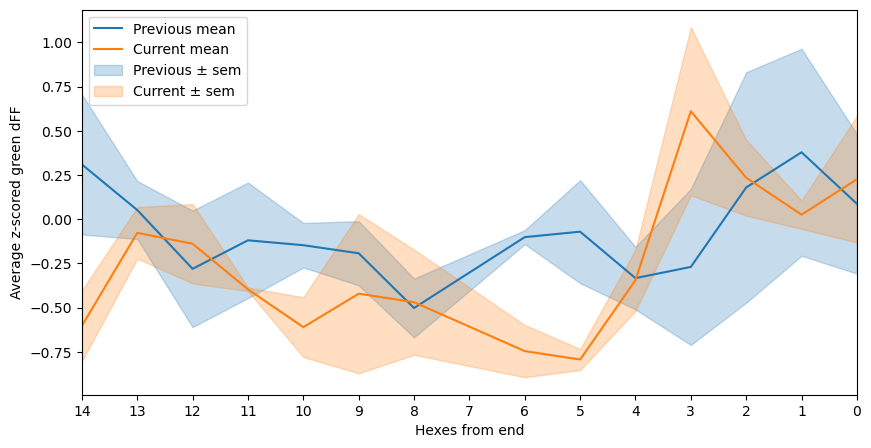

In [166]:
print('reward_t_2=[0], reward_t_1=[1], current trial=?')
plot_dff_ramps(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, max_hexes_from_end=14)


reward_t_2=[1], reward_t_1=[0], current trial=?


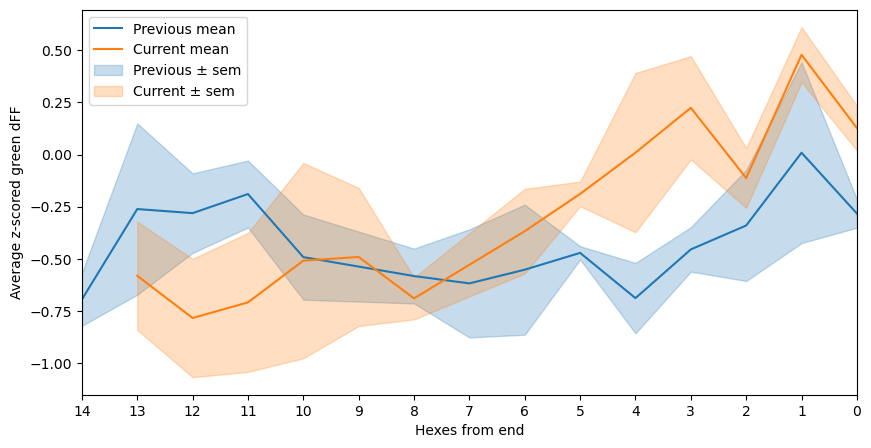

In [169]:
print('reward_t_2=[1], reward_t_1=[0], current trial=?')
plot_dff_ramps(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, max_hexes_from_end=14)
